# FE630 Portfolio Theory & Applications - Napat L.
# Final Project: Building and Backtesting a Long-Short Global Macro Portfolio with a Target Beta 

The purpose of this project is to implement portfolio optimization on Long/Short Global Macro Strategy based on a factor-based model with Beta Target to evaluate the sensitivity of strategy in variations of Beta.

# 1. Data preparation, Class and Method

## 1.1 Data source

We download data from Yahoo Finance and Fama French data from Wharton Research Data Services (wrds).

In [1]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 1.2 Investment Universe

We consider 13 ETFs from 01/01/2007 to 10/20/2016 which we download from Yahoo Finance as follows:
1. Currency Shares Euro Trist (FXE)
2. iShares MSCI Japan Index (EWJ)
3. SPDR GOLD Trust (GLD)
4. Powershares NASDAQ-100 Trust (QQQ)
5. SPDR S&P 500 (SPY)
6. iShares Lehman Short Treasury Bond (SHV)
7. PowerShares DB Agriculture Fund (DBA)
8. United States Oil Fund LP (USO)
9. SPDR S&P Biotech (XBI)
10. iShares S&P Latin America 40 Index (ILF)
11. SPDR S&P Emerging Middle Est & Africa (GAF)
12. iShares S&P Pacific ex-Japan Index Fund (EPP)
13. SPDR DJ Euro Stoxx 50 (FEZ)


In [2]:
markets = ['FXE', 'EWJ', 'GLD', 'QQQ', 'SPY', 'SHV', 'DBA', 'USO', 'XBI', 'ILF', 'GAF', 'EPP', 'FEZ']

market_data = pdr.get_data_yahoo(markets, start="2007-01-01", end="2016-10-20")

market_ret = market_data.ix['Close', :, :].dropna()
market_ret = market_ret.pct_change()

fama = pd.read_csv('4542f455888a6b40.csv', index_col='date', parse_dates=True)

df_market = pd.concat([market_ret, fama], axis=1, join='inner')
df_market = df_market.dropna()

R = df_market.ix[:,0:13]
ff = df_market.ix[:,13:(df_market.shape[1]-1)]

[*********************100%***********************]  13 of 13 downloaded


# 1.3 Investment Strategy

## 1.3.1 Overview
We will consider an portfolio optimization problem of the form:

\begin{equation*} 
\begin{aligned}
& \underset{w \in \mathbb{R}^n}{\text{maximize}}
& & \rho^Tw - \lambda(w - w_{previous})^T Q (w - w_{previous})  \\
& \text{subject to}
& & \sum_{i=1}^{n}\beta_i^mw_i = \beta_{Target}^m \\
& & & \sum_{i=1}^{n} w_i = 1, -2 \leq w_i \leq 2
\end{aligned}
\tag{1.1}\label{opt-1}
\end{equation*}

Portfolio's Target Beta:
\begin{equation*} \begin{aligned} &\beta_{Target}^m = 0.5, 1.0, 1.5  \end{aligned} \end{equation*}

The return of a security is given by the formula of The Fama French 3-factor model:
\begin{equation*} \begin{aligned} &r_i = r_f + \beta^3_i(r_M - r_f) + b^s_i r_{SMB} + b^v_ir_{HML} + \alpha_i + \varepsilon_i \end{aligned} \end{equation*}

$\mathbb{E}(\varepsilon_i) = 0$ in such a way that we have in terms of Expected Return:
\begin{equation*} \begin{aligned} &\rho_i = \rho_f + \beta^3_i(\rho_M - r_f) + b^s_i \rho_{SMB} + b^v_i\rho_{HML} + \alpha_i \end{aligned} \end{equation*}

$\beta_i^m = \frac{cov(r_i, r_{Brenchmark})}{\sigma^2(r_{Brenchmark})}$ is the Beta of security $S_i$ as defined in the CAPM Model so that $\beta^m_P = \sum_{i=1}^{n}\beta_i^mw_i$ is the Beta of the Portfolio.


$\lambda$ is a small regularization, 
$Q$ is the Indentity matrix or alternatively $Q = \Sigma$ in which $\Sigma$ is covariance matrix of security return given by Fama French 3-factor model

## 1.3.2 Model

We use Fama-French 3-factor  model to calculate the vector of return, $\rho$ with different portfolio's target Beta, $\beta_{T_1}^m$ = 0.5, $\beta_{T_2}^m$ = 1 and $\beta_{T_2}^m$ = 1.5 to measure behavior of risk relative to the market. We download the factor data from Wharton Research Data Services (wrds). The factors are recalculated depending on selected time periods as below:


- Short term (ST) model:	50 days
- Long term (LT) model:	200 days


In [ ]:
def optimization_strategy(self, wp, rho, lamda, Q, beta_market, beta_target):
    from scipy.optimize import minimize
    def fun_strategy(w, wp, rho, lamda, Q):
        return (-w).dot(rho)+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
    cons=({'type':'eq','fun':lambda w: (w).dot(beta_market)-beta_target}, 
        {'type':'eq','fun':lambda w: sum(w)-1})
    
    return minimize(fun_strategy, 13*[1/13], args=(wp, rho, lamda, Q), constraints=cons,bounds=[[-2,2]]*13)

def cal_beta_market(self, R_vec, Rm, N = 13):
        import numpy as np
        beta = []
        for i in range(0,N):
            sol = np.cov(R_vec.ix[:,i], R_vec.ix[:, Rm.upper()])/np.var(R_vec.ix[:, Rm.upper()])
            beta.append(sol[0,1])
        
        return np.array(beta)

## 1.4 Benchmark

There are 2 benchmarks which we use
1. The Market Portfolio (S&P 500)
2. The Mean-Variance Long/Short Portfolio with yearly return target of 15%, holdings between -2 and +2.

\begin{equation*} 
\begin{aligned}
& \underset{w \in \mathbb{R}^n}{\text{maximize}}
& & w^T \Sigma w - \lambda(w - w_{previous})^T Q (w - w_{previous})  \\
& \text{subject to}
& & \sum_{i=1}^{n}\rho^T w = 15\% \\
& & & \sum_{i=1}^{n} w_i = 1, -2 \leq w_i \leq 2
\end{aligned}
\tag{1.1}\label{opt-1}
\end{equation*}

In [ ]:
def optimization_minvar(self, wp, rho, lamda, Q, sigma):
    from scipy.optimize import minimize
    def fun_minvar(w, wp, rho, lamda, Q, sigma):
        return (w).dot(sigma.dot(w.T))+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
    cons=({'type':'eq','fun':lambda w: w.dot(rho)-15/100/252}, 
        {'type':'eq','fun':lambda w: sum(w)-1})
    
    return minimize(fun_minvar, 13*[1/13], args=(wp, rho, lamda, Q, sigma), constraints=cons,bounds=[[-2,2]]*13)

# 1.5 Risk Indicator

Our models will be assessed based on key indicators as below:
- Cumulated PnL or Return
- Daily Mean Geometric Return
- Daily Min Return
- Max 10 days Drawndown
- Volatility
- Sharpe Ratio
- Skewness
- Kurtosis
- Modified VaR
- CVaR

In [ ]:
def risk_indicator(self, perf = None):
        import numpy as np
        from scipy import stats
        import pandas as pd
        
        if perf is not None:
            perf = perf
        else:
            perf = self.performance

        annual_ret = perf.add(1).prod()** (252 / len(perf)) - 1
        mean_ret = np.mean(perf, axis=0)
        min_ret = np.min(perf, axis=0)
        volatility = np.std(perf, axis=0)
        sharpe = mean_ret/volatility
        skewness = stats.skew(perf, axis=0)
        kurtosis = stats.kurtosis(perf, axis=0)
    
        Roll_10Max = pd.rolling_max(perf.add(1).cumprod().subtract(1), 10, min_periods=1)
        day10_Drawdown = perf.add(1).cumprod().subtract(1).div(Roll_10Max) - 1
        Max_10day_Drawdown = pd.rolling_min(day10_Drawdown, 10, min_periods=1)
        max_10dd = Max_10day_Drawdown.min()
    
        VaR_list = []
        for i in perf.columns:
            VaR_list.append(np.percentile(perf.ix[:,i], .01))
    
        CVaR_list = []
        for i in perf.columns:
            CVaR_list.append(np.mean(np.sort(perf.ix[:,i].values)[np.sort(perf.ix[:,i].values) <= np.percentile(perf.ix[:,i], .01)]))
        
        
        if perf is not None:
            result = pd.DataFrame(columns=perf.columns)
        else:
            result = pd.DataFrame(columns=['Beta=0.5', 'Beta=1.0', 'Beta=1.5', 'MinVar', self.benchmark])
        
        result.loc['Annual.Return'] = annual_ret
        result.loc['Daily.Mean'] = mean_ret
        result.loc['Daily.Min'] = min_ret
        result.loc['Max10.DD'] = max_10dd
        result.loc['Volatility'] = volatility
        result.loc['Sharpe.Ratio'] = sharpe
        result.loc['Skewness'] = skewness 
        result.loc['Kurtosis'] = kurtosis
        result.loc['Mod.VaR'] = VaR_list
        result.loc['CVaR'] = CVaR_list
        
        return result

# 1.6 Backtesting

We split time period for backtesting into 3 periods of time, Before Sub-prime crisis, During Sub-prime Crisis and After Sub-prime Crisis. The detail is as below:


- Before Sub-prime Crisis: March 19, 2007 - January 31, 2008 
- During Sub-prime Crisis: February 2, 2008 - June 01, 2009 
- Before Sub-prime Crisis: June 02, 2009 - October 20, 2016 

In [3]:
from datetime import datetime

bc_return = R[R.index <= datetime.strptime("2008-01-31", '%Y-%m-%d')]
dc_return = R[(R.index >= datetime.strptime("2008-02-01", '%Y-%m-%d')) & (R.index <= datetime.strptime("2009-06-01", '%Y-%m-%d'))]
ac_return = R[R.index >= datetime.strptime("2009-06-02", '%Y-%m-%d')]

bc_fama = ff[ff.index <= datetime.strptime("2008-01-31", '%Y-%m-%d')]
dc_fama = ff[(ff.index >= datetime.strptime("2008-02-01", '%Y-%m-%d')) & (R.index <= datetime.strptime("2009-06-01", '%Y-%m-%d'))]
ac_fama = ff[ff.index >= datetime.strptime("2009-06-02", '%Y-%m-%d')]

bc_bench_return = bc_return.SPY
dc_bench_return = dc_return.SPY
ac_bench_return = dc_return.SPY

# 1.7 Strategy Performance Class Object

In [7]:
class portfolio_startegy:
    
    def __init__(self, data_market, data_fama, term, Q_ident = False, lamda=1/2, benchmark = 'SPY'):
        self.data_market = data_market
        self.data_fama = data_fama
        self.term = term
        self.lamda = lamda
        self.Q_ident = Q_ident
        self.benchmark = benchmark
        self.performance = None
        
    def cal_beta_market(self, R_vec, Rm, N = 13):
        import numpy as np
        beta = []
        for i in range(0,N):
            sol = np.cov(R_vec.ix[:,i], R_vec.ix[:, Rm.upper()])/np.var(R_vec.ix[:, Rm.upper()])
            beta.append(sol[0,1])
        
        return np.array(beta)
    
    def optimization_strategy(self, wp, rho, lamda, Q, beta_market, beta_target):
        from scipy.optimize import minimize
        def fun_strategy(w, wp, rho, lamda, Q):
            return (-w).dot(rho)+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
        cons=({'type':'eq','fun':lambda w: (w).dot(beta_market)-beta_target}, 
               {'type':'eq','fun':lambda w: sum(w)-1})
    
        return minimize(fun_strategy, 13*[1/13], args=(wp, rho, lamda, Q), constraints=cons,bounds=[[-2,2]]*13)

    def optimization_minvar(self, wp, rho, lamda, Q, sigma):
        from scipy.optimize import minimize
        def fun_minvar(w, wp, rho, lamda, Q, sigma):
            return (w).dot(sigma.dot(w.T))+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
        cons=({'type':'eq','fun':lambda w: w.dot(rho)-15/100/252}, 
                {'type':'eq','fun':lambda w: sum(w)-1})
    
        return minimize(fun_minvar, 13*[1/13], args=(wp, rho, lamda, Q, sigma), constraints=cons,bounds=[[-2,2]]*13)
    
    def strategy_performace(self):
        import numpy as np
        import statsmodels.api as sm
        import pandas as pd
        
        mkt_ret, fama_ret, term, lamda, benchmark = self.data_market, self.data_fama, self.term, self.lamda, self.benchmark
        
        wp1 = np.zeros(13)
        wp2 = np.zeros(13)
        wp3 = np.zeros(13)
        wp_minvar = np.zeros(13)
        check_loop = 0
    
        for i in range (term,len(mkt_ret)):
            if i%term==0:
    
                beta_fama = sm.OLS(mkt_ret[(i-term):i].subtract(fama_ret['rf'][(i-term):i] ,axis=0), sm.add_constant(fama_ret[['mktrf','smb','hml']][(i-term):i])).fit().params.values
                ri = (sm.add_constant(fama_ret[['mktrf','smb','hml']][(i-term):i]).dot(beta_fama)).add(fama_ret['rf'][(i-term):i], axis=0)
                rho = ri.mean()
                beta_market = self.cal_beta_market(mkt_ret[(i-term):i], Rm=benchmark)
            
                sigma = ri.cov() 
                
                Q = np.where(self.Q_ident == False, sigma, np.diag((13*[1])))
            
                solution1 = self.optimization_strategy(wp1, rho, lamda, Q, beta_market, beta_target = 0.5)
                wp1 = solution1.x
            
                solution2 = self.optimization_strategy(wp2, rho, lamda, Q, beta_market, beta_target = 1.0)
                wp2 = solution2.x
            
                solution3 = self.optimization_strategy(wp3, rho, lamda, Q, beta_market, beta_target = 1.5)
                wp3 = solution3.x
            
                solution_minvar = self.optimization_minvar(wp_minvar, rho, lamda, Q, sigma)
                wp_minvar = solution_minvar.x
            
                if check_loop == 0:
                    return_strategy1 = mkt_ret[(i-term):i].dot(wp1)
                    return_strategy2 = mkt_ret[(i-term):i].dot(wp2)
                    return_strategy3 = mkt_ret[(i-term):i].dot(wp3)
                    return_strategy_minvar = mkt_ret[(i-term):i].dot(wp_minvar)
                    return_benchmark = mkt_ret[(i-term):i][benchmark]
                else:
                    return_strategy1 = pd.concat([return_strategy1, mkt_ret[(i-term):i].dot(wp1)], axis=0)
                    return_strategy2 = pd.concat([return_strategy2, mkt_ret[(i-term):i].dot(wp2)], axis=0)
                    return_strategy3 = pd.concat([return_strategy3, mkt_ret[(i-term):i].dot(wp3)], axis=0)
                    return_strategy_minvar = pd.concat([return_strategy_minvar, mkt_ret[(i-term):i].dot(wp_minvar)], axis=0)
                    return_benchmark = pd.concat([return_benchmark, mkt_ret[(i-term):i][benchmark]], axis=0)
                check_loop += 1
    
        performance = pd.DataFrame({'Beta=0.5':return_strategy1,
                        'Beta=1.0':return_strategy2,
                        'Beta=1.5':return_strategy3,
                        'MinVar':return_strategy_minvar,
                        benchmark:return_benchmark})
        self.performance = performance
        self.return_strategy1 = return_strategy1
        self.return_strategy2 = return_strategy2
        self.return_strategy3 = return_strategy3
        self.underlying_analytics()
        return performance
    
    def performance_plot(self):
        import matplotlib.pyplot as plt
        from matplotlib import style
        import matplotlib.dates as mdates
        
        if self.performance is None:
            self.strategy_performace()
        perf = self.performance
    
        term, benchmark = self.term, self.benchmark
    
        style.use('ggplot')
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle('Portfolio Strategy Performance', fontsize=18, fontweight='bold')
    
        ax1 = plt.subplot2grid((15, 10), (0, 0), rowspan=10, colspan=15)
        ax1.plot(perf['Beta=0.5'].add(1).cumprod().subtract(1), c='orange',  label = "Beta=0.5 {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=0.5']))
        ax1.annotate("{0}: {1:0.4f}".format('Beta=0.5', perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=0.5']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=0.5']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
            
        ax1.plot(perf['Beta=1.0'].add(1).cumprod().subtract(1), c='dodgerblue', label = "Beta=1.0 {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.0']))
        ax1.annotate("{0}: {1:0.4f}".format('Beta=1.0', perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.0']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.0']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.plot(perf['Beta=1.5'].add(1).cumprod().subtract(1), c='limegreen', label = "Beta=1.5 {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.5']))
        ax1.annotate("{0}: {1:0.4f}".format('Beta=1.5', perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.5']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.5']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.plot(perf['MinVar'].add(1).cumprod().subtract(1), c='magenta', label = "MinVar {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'MinVar']))
        ax1.annotate("{0}: {1:0.4f}".format('MinVar', perf.add(1).cumprod().subtract(1).ix[-1, 'MinVar']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'MinVar']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.plot(perf[benchmark].add(1).cumprod().subtract(1), c='black', label = "{0} {1} terms, Cumulative return = {2:0.4f}".format(benchmark, term, perf.add(1).cumprod().subtract(1).ix[-1, benchmark]))
        ax1.annotate("{0}: {1:0.4f}".format(benchmark, perf.add(1).cumprod().subtract(1).ix[-1, benchmark]), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, benchmark]), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.set_title('{0}-terms factor model with \n Min-variance strategy and {1} benchmark \n The best strategy is {2} with {3:0.4f} return'.format(term, benchmark,perf.add(1).cumprod().subtract(1).ix[-1,:].index[perf.add(1).cumprod().subtract(1).ix[-1,:] == perf.add(1).cumprod().subtract(1).ix[-1,:].max()].tolist()[0], perf.add(1).cumprod().subtract(1).ix[-1,:].max()))
        ax1.legend()
    
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
        ax1.set_ylabel('Return')
        plt.xticks(rotation=45)
        plt.xlabel('Date Hours:Minutes')
        plt.plot()
    
    def risk_indicator(self, perf = None):
        import numpy as np
        from scipy import stats
        import pandas as pd
        
        if perf is not None:
            perf = perf
        else:
            perf = self.performance

        annual_ret = perf.add(1).prod()** (252 / len(perf)) - 1
        mean_ret = np.mean(perf, axis=0)
        min_ret = np.min(perf, axis=0)
        volatility = np.std(perf, axis=0)
        sharpe = mean_ret/volatility
        skewness = stats.skew(perf, axis=0)
        kurtosis = stats.kurtosis(perf, axis=0)
    
        Roll_10Max = pd.rolling_max(perf.add(1).cumprod().subtract(1), 10, min_periods=1)
        day10_Drawdown = perf.add(1).cumprod().subtract(1).div(Roll_10Max) - 1
        Max_10day_Drawdown = pd.rolling_min(day10_Drawdown, 10, min_periods=1)
        max_10dd = Max_10day_Drawdown.min()
    
        VaR_list = []
        for i in perf.columns:
            VaR_list.append(np.percentile(perf.ix[:,i], .01))
    
        CVaR_list = []
        for i in perf.columns:
            CVaR_list.append(np.mean(np.sort(perf.ix[:,i].values)[np.sort(perf.ix[:,i].values) <= np.percentile(perf.ix[:,i], .01)]))
        
        
        if perf is not None:
            result = pd.DataFrame(columns=perf.columns)
        else:
            result = pd.DataFrame(columns=['Beta=0.5', 'Beta=1.0', 'Beta=1.5', 'MinVar', self.benchmark])
        
        result.loc['Annual.Return'] = annual_ret
        result.loc['Daily.Mean'] = mean_ret
        result.loc['Daily.Min'] = min_ret
        result.loc['Max10.DD'] = max_10dd
        result.loc['Volatility'] = volatility
        result.loc['Sharpe.Ratio'] = sharpe
        result.loc['Skewness'] = skewness 
        result.loc['Kurtosis'] = kurtosis
        result.loc['Mod.VaR'] = VaR_list
        result.loc['CVaR'] = CVaR_list
        
        return result
    
    def underlying_analytics(self):
        import pandas as pd
        
        mkt_data = self.data_market.ix[0:len(self.return_strategy1),:]
        
        underly1 = pd.concat([mkt_data, self.return_strategy1.rename('Beta=0.5')], axis=1)
        self.underly1 = self.risk_indicator(underly1)
        
        underly2 = pd.concat([mkt_data, self.return_strategy2.rename('Beta=1.0')], axis=1)
        self.underly2 = self.risk_indicator(underly2)
        
        underly3 = pd.concat([mkt_data, self.return_strategy3.rename('Beta=1.5')], axis=1)
        self.underly3 = self.risk_indicator(underly3)


# 2. Strategy Performance

# 2.1 Before Sub-prime crisis

## 2.1.1 Before Sub-prime crisis Short-term model

In [9]:
port_bc_short = portfolio_startegy(data_market = bc_return, data_fama = bc_fama, term = 50)

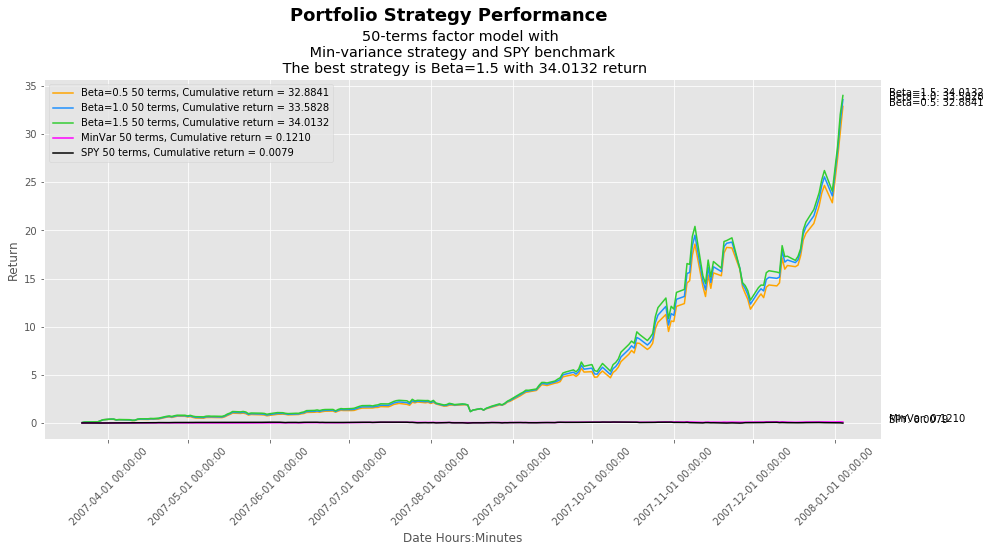

In [10]:
port_bc_short.performance_plot()

## 2.1.2 Before Sub-prime crisis Short term Risk Indicator

In [11]:
port_bc_short.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,83.682667,85.888892,87.253397,0.154786,0.009986
Daily.Mean,0.019665,0.019844,0.020017,0.000595,0.000095
Daily.Min,-0.231189,-0.237427,-0.243651,-0.022674,-0.029634
Max10.DD,-0.382735,-0.406735,-0.430465,-0.545101,-0.912773
Volatility,0.061456,0.062604,0.064241,0.006925,0.010531
Sharpe.Ratio,0.319988,0.316982,0.311598,0.085955,0.009020
Skewness,-0.326706,-0.356551,-0.401695,-0.175308,-0.273718
Kurtosis,2.335102,2.426590,2.470897,0.505863,0.827768
Mod.VaR,-0.231046,-0.237301,-0.243566,-0.022541,-0.029590
CVaR,-0.231189,-0.237427,-0.243651,-0.022674,-0.029634


## 2.1.3 Before Sub-prime crisis Short term Underlyings Analytics 

### 2.1.3.1 Beta = 0.5

In [12]:
port_bc_short.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,0.433057,0.190521,-1.388513e-01,0.187019,0.139313,0.228235,0.411973,0.545208,0.151621,0.007746,0.009986,0.790154,0.355902,83.682667
Daily.Mean,0.001507,0.000859,-5.435303e-04,0.000761,0.000526,0.000931,0.001429,0.002005,0.000634,0.000031,0.000095,0.002453,0.001273,0.019665
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.231189
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.100694,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.382735
Volatility,0.012498,0.018210,9.941789e-03,0.012705,0.004100,0.015152,0.010838,0.023512,0.012120,0.000837,0.010531,0.016764,0.011343,0.061456
Sharpe.Ratio,0.120583,0.047154,-5.467127e-02,0.059918,0.128329,0.061465,0.131833,0.085271,0.052310,0.037023,0.009020,0.146352,0.112237,0.319988
Skewness,-0.389784,-0.336518,-1.406640e-01,-0.022843,-0.372819,-0.415278,-0.433763,-0.109052,-0.358162,-3.230361,-0.273718,0.149796,0.089010,-0.326706
Kurtosis,0.455846,0.221800,7.460252e-01,0.350734,0.251050,0.410053,1.550221,0.723569,0.996538,11.323965,0.827768,0.083218,0.106988,2.335102
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049828,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.231046
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.231189


### 2.1.3.2 Beta = 1.0

In [13]:
port_bc_short.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,0.433057,0.190521,-1.388513e-01,0.187019,0.139313,0.228235,0.411973,0.545208,0.151621,0.007746,0.009986,0.790154,0.355902,85.888892
Daily.Mean,0.001507,0.000859,-5.435303e-04,0.000761,0.000526,0.000931,0.001429,0.002005,0.000634,0.000031,0.000095,0.002453,0.001273,0.019844
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.237427
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.100694,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.406735
Volatility,0.012498,0.018210,9.941789e-03,0.012705,0.004100,0.015152,0.010838,0.023512,0.012120,0.000837,0.010531,0.016764,0.011343,0.062604
Sharpe.Ratio,0.120583,0.047154,-5.467127e-02,0.059918,0.128329,0.061465,0.131833,0.085271,0.052310,0.037023,0.009020,0.146352,0.112237,0.316982
Skewness,-0.389784,-0.336518,-1.406640e-01,-0.022843,-0.372819,-0.415278,-0.433763,-0.109052,-0.358162,-3.230361,-0.273718,0.149796,0.089010,-0.356551
Kurtosis,0.455846,0.221800,7.460252e-01,0.350734,0.251050,0.410053,1.550221,0.723569,0.996538,11.323965,0.827768,0.083218,0.106988,2.426590
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049828,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.237301
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.237427


### 2.1.3.3 Beta = 1.5

In [14]:
port_bc_short.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,0.433057,0.190521,-1.388513e-01,0.187019,0.139313,0.228235,0.411973,0.545208,0.151621,0.007746,0.009986,0.790154,0.355902,87.253397
Daily.Mean,0.001507,0.000859,-5.435303e-04,0.000761,0.000526,0.000931,0.001429,0.002005,0.000634,0.000031,0.000095,0.002453,0.001273,0.020017
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.243651
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.100694,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.430465
Volatility,0.012498,0.018210,9.941789e-03,0.012705,0.004100,0.015152,0.010838,0.023512,0.012120,0.000837,0.010531,0.016764,0.011343,0.064241
Sharpe.Ratio,0.120583,0.047154,-5.467127e-02,0.059918,0.128329,0.061465,0.131833,0.085271,0.052310,0.037023,0.009020,0.146352,0.112237,0.311598
Skewness,-0.389784,-0.336518,-1.406640e-01,-0.022843,-0.372819,-0.415278,-0.433763,-0.109052,-0.358162,-3.230361,-0.273718,0.149796,0.089010,-0.401695
Kurtosis,0.455846,0.221800,7.460252e-01,0.350734,0.251050,0.410053,1.550221,0.723569,0.996538,11.323965,0.827768,0.083218,0.106988,2.470897
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049828,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.243566
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.243651


## 2.1.4 Before Sub-prime crisis Long-term model

In [15]:
port_bc_long = portfolio_startegy(data_market = bc_return, data_fama = bc_fama, term = 200)

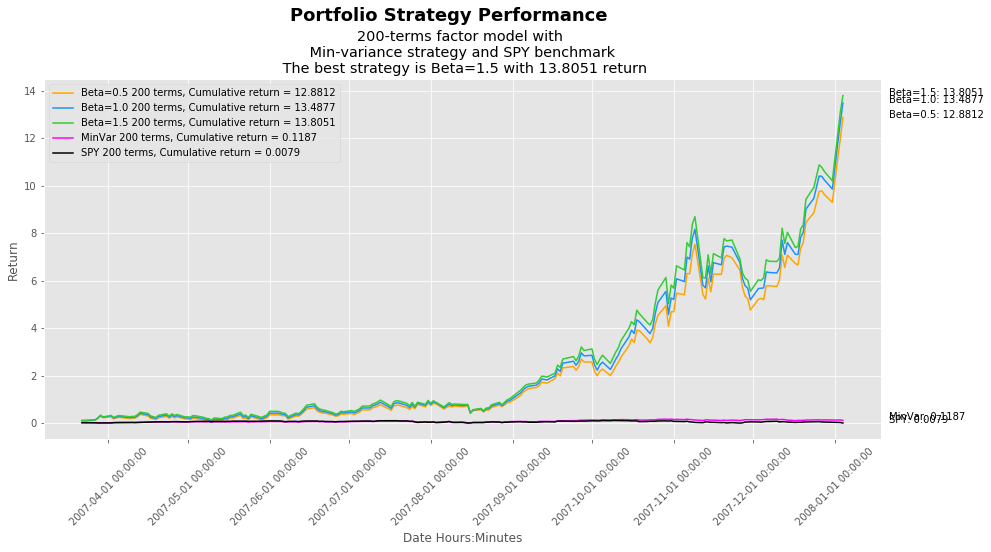

In [16]:
port_bc_long.performance_plot()

## 2.1.5 Before Sub-prime crisis Long term Risk Indicator

In [17]:
port_bc_long.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,26.507962,28.030877,28.834490,0.151837,0.009986
Daily.Mean,0.015407,0.015706,0.015924,0.000595,0.000095
Daily.Min,-0.247432,-0.257206,-0.265064,-0.019899,-0.029634
Max10.DD,-0.847006,-0.731309,-0.638335,-0.815172,-0.912773
Volatility,0.065584,0.066802,0.068356,0.008259,0.010531
Sharpe.Ratio,0.234919,0.235118,0.232951,0.072068,0.009020
Skewness,-0.366605,-0.371958,-0.371408,-0.236628,-0.273718
Kurtosis,0.688697,0.759644,0.772540,0.008844,0.827768
Mod.VaR,-0.246224,-0.255919,-0.263736,-0.019886,-0.029590
CVaR,-0.247432,-0.257206,-0.265064,-0.019899,-0.029634


## 2.1.6 Before Sub-prime crisis Short term Underlyings Analytics 

### 2.1.6.1 Beta = 0.5

In [18]:
port_bc_long.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,0.433057,0.190521,-1.388513e-01,0.187019,0.139313,0.228235,0.411973,0.545208,0.151621,0.007746,0.009986,0.790154,0.355902,26.507962
Daily.Mean,0.001507,0.000859,-5.435303e-04,0.000761,0.000526,0.000931,0.001429,0.002005,0.000634,0.000031,0.000095,0.002453,0.001273,0.015407
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.247432
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.100694,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.847006
Volatility,0.012498,0.018210,9.941789e-03,0.012705,0.004100,0.015152,0.010838,0.023512,0.012120,0.000837,0.010531,0.016764,0.011343,0.065584
Sharpe.Ratio,0.120583,0.047154,-5.467127e-02,0.059918,0.128329,0.061465,0.131833,0.085271,0.052310,0.037023,0.009020,0.146352,0.112237,0.234919
Skewness,-0.389784,-0.336518,-1.406640e-01,-0.022843,-0.372819,-0.415278,-0.433763,-0.109052,-0.358162,-3.230361,-0.273718,0.149796,0.089010,-0.366605
Kurtosis,0.455846,0.221800,7.460252e-01,0.350734,0.251050,0.410053,1.550221,0.723569,0.996538,11.323965,0.827768,0.083218,0.106988,0.688697
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049828,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.246224
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.247432


### 2.1.6.2 Beta = 1.0

In [19]:
port_bc_long.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,0.433057,0.190521,-1.388513e-01,0.187019,0.139313,0.228235,0.411973,0.545208,0.151621,0.007746,0.009986,0.790154,0.355902,28.030877
Daily.Mean,0.001507,0.000859,-5.435303e-04,0.000761,0.000526,0.000931,0.001429,0.002005,0.000634,0.000031,0.000095,0.002453,0.001273,0.015706
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.257206
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.100694,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.731309
Volatility,0.012498,0.018210,9.941789e-03,0.012705,0.004100,0.015152,0.010838,0.023512,0.012120,0.000837,0.010531,0.016764,0.011343,0.066802
Sharpe.Ratio,0.120583,0.047154,-5.467127e-02,0.059918,0.128329,0.061465,0.131833,0.085271,0.052310,0.037023,0.009020,0.146352,0.112237,0.235118
Skewness,-0.389784,-0.336518,-1.406640e-01,-0.022843,-0.372819,-0.415278,-0.433763,-0.109052,-0.358162,-3.230361,-0.273718,0.149796,0.089010,-0.371958
Kurtosis,0.455846,0.221800,7.460252e-01,0.350734,0.251050,0.410053,1.550221,0.723569,0.996538,11.323965,0.827768,0.083218,0.106988,0.759644
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049828,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.255919
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.257206


### 2.1.6.3 Beta = 1.5

In [20]:
port_bc_long.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,0.433057,0.190521,-1.388513e-01,0.187019,0.139313,0.228235,0.411973,0.545208,0.151621,0.007746,0.009986,0.790154,0.355902,28.834490
Daily.Mean,0.001507,0.000859,-5.435303e-04,0.000761,0.000526,0.000931,0.001429,0.002005,0.000634,0.000031,0.000095,0.002453,0.001273,0.015924
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.265064
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.100694,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.638335
Volatility,0.012498,0.018210,9.941789e-03,0.012705,0.004100,0.015152,0.010838,0.023512,0.012120,0.000837,0.010531,0.016764,0.011343,0.068356
Sharpe.Ratio,0.120583,0.047154,-5.467127e-02,0.059918,0.128329,0.061465,0.131833,0.085271,0.052310,0.037023,0.009020,0.146352,0.112237,0.232951
Skewness,-0.389784,-0.336518,-1.406640e-01,-0.022843,-0.372819,-0.415278,-0.433763,-0.109052,-0.358162,-3.230361,-0.273718,0.149796,0.089010,-0.371408
Kurtosis,0.455846,0.221800,7.460252e-01,0.350734,0.251050,0.410053,1.550221,0.723569,0.996538,11.323965,0.827768,0.083218,0.106988,0.772540
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049828,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.263736
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.265064


# 2.2 During Sub-prime crisis

## 2.2.1 During Sub-prime crisis Short-term model

In [21]:
port_dc_short = portfolio_startegy(data_market = dc_return, data_fama = dc_fama, term = 50)

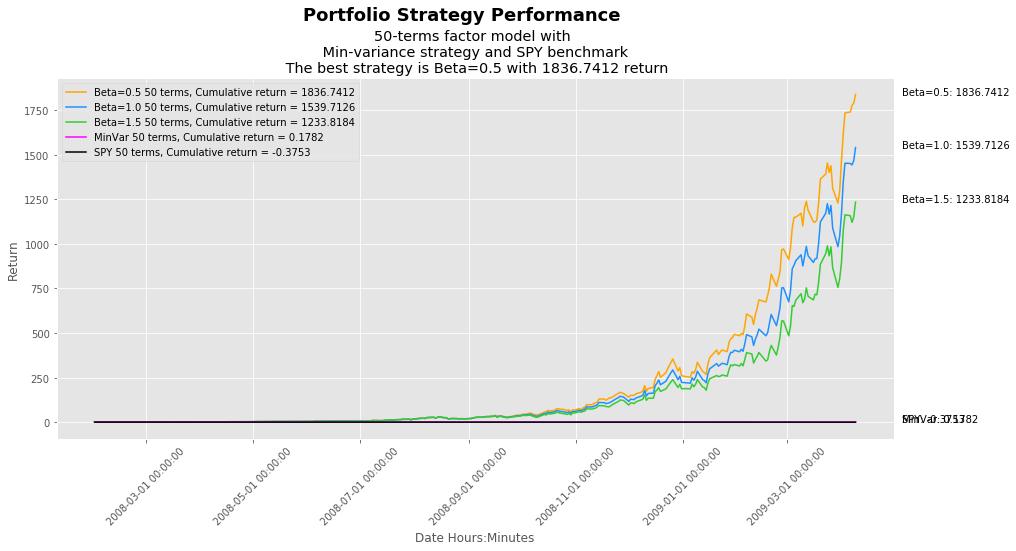

In [22]:
port_dc_short.performance_plot()

## 2.2.2 During Sub-prime crisis Risk Indicator

In [23]:
port_dc_short.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,551.075991,475.086829,394.318000,0.147658,-0.326492
Daily.Mean,0.028947,0.028698,0.028536,0.000595,-0.001219
Daily.Min,-0.250831,-0.261798,-0.271640,-0.031920,-0.098448
Max10.DD,-1.371611,-1.481240,-1.562644,-5.839213,-10.464584
Volatility,0.085137,0.089220,0.095738,0.009860,0.026473
Sharpe.Ratio,0.340009,0.321657,0.298069,0.060368,-0.046035
Skewness,-0.068157,-0.042960,0.009094,0.075266,0.500905
Kurtosis,0.754356,0.913094,1.154774,1.150592,4.858104
Mod.VaR,-0.249608,-0.260152,-0.270841,-0.031888,-0.098153
CVaR,-0.250831,-0.261798,-0.271640,-0.031920,-0.098448


## 2.2.3 During Sub-prime crisis Underlyings Analytics

### 2.2.3.1 Beta = 0.5

In [24]:
port_dc_short.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.280662,-0.378196,-0.288650,-0.417269,-0.099971,-0.291803,-0.046992,-0.330427,-0.232397,-0.001066,-0.326492,-0.513426,-0.146786,551.075991
Daily.Mean,-0.001043,-0.001290,-0.000965,-0.001603,-0.000370,-0.000821,0.000015,-0.000583,-0.000729,-0.000004,-0.001219,-0.002197,-0.000333,0.028947
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.250831
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-9.394621,-22.121154,-3.926552,-8.261937,-17.010006,-10.464584,-93.714279,-36.071185,-1.371611
Volatility,0.022909,0.034563,0.027915,0.032930,0.009830,0.033059,0.020364,0.045014,0.025359,0.000602,0.026473,0.036217,0.024401,0.085137
Sharpe.Ratio,-0.045508,-0.037337,-0.034567,-0.048678,-0.037605,-0.024838,0.000756,-0.012953,-0.028740,-0.006731,-0.046035,-0.060674,-0.013666,0.340009
Skewness,-0.235849,0.512223,0.740479,0.609103,0.355459,0.134344,0.434655,0.457303,0.399126,-1.108524,0.500905,0.087545,0.411076,-0.068157
Kurtosis,0.930516,3.920646,4.995535,4.359820,1.316762,3.706935,3.556981,5.344111,3.022657,9.294882,4.858104,0.227851,2.870836,0.754356
Mod.VaR,-0.085686,-0.112093,-0.103553,-0.113850,-0.030599,-0.135236,-0.073818,-0.192985,-0.089252,-0.003585,-0.098153,-0.106814,-0.079549,-0.249608
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.250831


### 2.2.3.2 Beta = 1.0

In [25]:
port_dc_short.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.280662,-0.378196,-0.288650,-0.417269,-0.099971,-0.291803,-0.046992,-0.330427,-0.232397,-0.001066,-0.326492,-0.513426,-0.146786,475.086829
Daily.Mean,-0.001043,-0.001290,-0.000965,-0.001603,-0.000370,-0.000821,0.000015,-0.000583,-0.000729,-0.000004,-0.001219,-0.002197,-0.000333,0.028698
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.261798
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-9.394621,-22.121154,-3.926552,-8.261937,-17.010006,-10.464584,-93.714279,-36.071185,-1.481240
Volatility,0.022909,0.034563,0.027915,0.032930,0.009830,0.033059,0.020364,0.045014,0.025359,0.000602,0.026473,0.036217,0.024401,0.089220
Sharpe.Ratio,-0.045508,-0.037337,-0.034567,-0.048678,-0.037605,-0.024838,0.000756,-0.012953,-0.028740,-0.006731,-0.046035,-0.060674,-0.013666,0.321657
Skewness,-0.235849,0.512223,0.740479,0.609103,0.355459,0.134344,0.434655,0.457303,0.399126,-1.108524,0.500905,0.087545,0.411076,-0.042960
Kurtosis,0.930516,3.920646,4.995535,4.359820,1.316762,3.706935,3.556981,5.344111,3.022657,9.294882,4.858104,0.227851,2.870836,0.913094
Mod.VaR,-0.085686,-0.112093,-0.103553,-0.113850,-0.030599,-0.135236,-0.073818,-0.192985,-0.089252,-0.003585,-0.098153,-0.106814,-0.079549,-0.260152
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.261798


### 2.2.3.3 Beta = 1.5

In [26]:
port_dc_short.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.280662,-0.378196,-0.288650,-0.417269,-0.099971,-0.291803,-0.046992,-0.330427,-0.232397,-0.001066,-0.326492,-0.513426,-0.146786,394.318000
Daily.Mean,-0.001043,-0.001290,-0.000965,-0.001603,-0.000370,-0.000821,0.000015,-0.000583,-0.000729,-0.000004,-0.001219,-0.002197,-0.000333,0.028536
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.271640
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-9.394621,-22.121154,-3.926552,-8.261937,-17.010006,-10.464584,-93.714279,-36.071185,-1.562644
Volatility,0.022909,0.034563,0.027915,0.032930,0.009830,0.033059,0.020364,0.045014,0.025359,0.000602,0.026473,0.036217,0.024401,0.095738
Sharpe.Ratio,-0.045508,-0.037337,-0.034567,-0.048678,-0.037605,-0.024838,0.000756,-0.012953,-0.028740,-0.006731,-0.046035,-0.060674,-0.013666,0.298069
Skewness,-0.235849,0.512223,0.740479,0.609103,0.355459,0.134344,0.434655,0.457303,0.399126,-1.108524,0.500905,0.087545,0.411076,0.009094
Kurtosis,0.930516,3.920646,4.995535,4.359820,1.316762,3.706935,3.556981,5.344111,3.022657,9.294882,4.858104,0.227851,2.870836,1.154774
Mod.VaR,-0.085686,-0.112093,-0.103553,-0.113850,-0.030599,-0.135236,-0.073818,-0.192985,-0.089252,-0.003585,-0.098153,-0.106814,-0.079549,-0.270841
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.271640


## 2.2.4 During Sub-prime crisis Long-term model

In [27]:
port_dc_long = portfolio_startegy(data_market = dc_return, data_fama = dc_fama, term = 200)

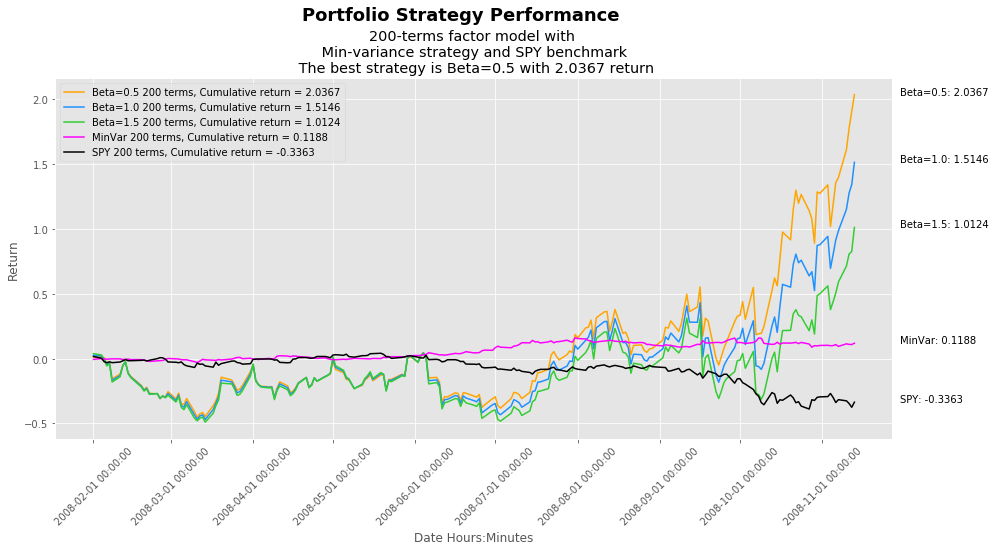

In [28]:
port_dc_long.performance_plot()

## 2.2.5 During Sub-prime crisis Risk Indicator

In [29]:
port_dc_long.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,3.053462,2.195881,1.413748,0.151936,-0.403419
Daily.Mean,0.008612,0.008161,0.007733,0.000595,-0.001736
Daily.Min,-0.244852,-0.292444,-0.341090,-0.034348,-0.098448
Max10.DD,-39.203537,-31.517230,-31.405201,-68.648531,-10.464584
Volatility,0.077212,0.082947,0.090413,0.008221,0.025115
Sharpe.Ratio,0.111531,0.098382,0.085535,0.072407,-0.069119
Skewness,-0.364542,-0.396681,-0.349710,-0.092394,0.986478
Kurtosis,0.850219,1.615831,2.480605,3.080791,8.556074
Mod.VaR,-0.244668,-0.291987,-0.340355,-0.034291,-0.098048
CVaR,-0.244852,-0.292444,-0.341090,-0.034348,-0.098448


## 2.2.6  During Sub-prime crisis Short term Underlyings Analytics 

### 2.2.6.1 Beta = 0.5

In [30]:
port_dc_long.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.392670,-0.540468,-0.345158,-0.496796,-0.170502,-0.442836,-0.257690,-0.529142,-0.390641,0.000799,-0.403419,-0.387996,-0.032268,3.053462
Daily.Mean,-0.001701,-0.002540,-0.001282,-0.002248,-0.000704,-0.001807,-0.000965,-0.001953,-0.001665,0.000003,-0.001736,-0.001496,0.000136,0.008612
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.244852
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-9.394621,-22.121154,-3.926552,-8.261937,-6.249844,-10.464584,-93.714279,-12.577020,-39.203537
Volatility,0.023407,0.033018,0.028335,0.031014,0.008674,0.031951,0.020865,0.045597,0.024534,0.000680,0.025115,0.029956,0.023206,0.077212
Sharpe.Ratio,-0.072669,-0.076912,-0.045261,-0.072481,-0.081160,-0.056559,-0.046254,-0.042830,-0.067854,0.005004,-0.069119,-0.049930,0.005876,0.111531
Skewness,-0.311663,0.626055,0.958663,1.077409,0.288442,0.212610,0.488243,0.646006,0.637260,-1.072546,0.986478,-0.103257,0.772871,-0.364542
Kurtosis,0.974582,5.608939,7.083409,8.205813,1.496846,5.734831,4.315296,7.778528,5.343745,8.049350,8.556074,0.549461,5.006287,0.850219
Mod.VaR,-0.085811,-0.112135,-0.103728,-0.114004,-0.025700,-0.135284,-0.073957,-0.193547,-0.089354,-0.003597,-0.098048,-0.105047,-0.068839,-0.244668
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.244852


### 2.2.6.2 Beta = 1.0

In [31]:
port_dc_long.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.392670,-0.540468,-0.345158,-0.496796,-0.170502,-0.442836,-0.257690,-0.529142,-0.390641,0.000799,-0.403419,-0.387996,-0.032268,2.195881
Daily.Mean,-0.001701,-0.002540,-0.001282,-0.002248,-0.000704,-0.001807,-0.000965,-0.001953,-0.001665,0.000003,-0.001736,-0.001496,0.000136,0.008161
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.292444
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-9.394621,-22.121154,-3.926552,-8.261937,-6.249844,-10.464584,-93.714279,-12.577020,-31.517230
Volatility,0.023407,0.033018,0.028335,0.031014,0.008674,0.031951,0.020865,0.045597,0.024534,0.000680,0.025115,0.029956,0.023206,0.082947
Sharpe.Ratio,-0.072669,-0.076912,-0.045261,-0.072481,-0.081160,-0.056559,-0.046254,-0.042830,-0.067854,0.005004,-0.069119,-0.049930,0.005876,0.098382
Skewness,-0.311663,0.626055,0.958663,1.077409,0.288442,0.212610,0.488243,0.646006,0.637260,-1.072546,0.986478,-0.103257,0.772871,-0.396681
Kurtosis,0.974582,5.608939,7.083409,8.205813,1.496846,5.734831,4.315296,7.778528,5.343745,8.049350,8.556074,0.549461,5.006287,1.615831
Mod.VaR,-0.085811,-0.112135,-0.103728,-0.114004,-0.025700,-0.135284,-0.073957,-0.193547,-0.089354,-0.003597,-0.098048,-0.105047,-0.068839,-0.291987
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.292444


### 2.2.6.3 Beta = 1.5

In [32]:
port_dc_long.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.392670,-0.540468,-0.345158,-0.496796,-0.170502,-0.442836,-0.257690,-0.529142,-0.390641,0.000799,-0.403419,-0.387996,-0.032268,1.413748
Daily.Mean,-0.001701,-0.002540,-0.001282,-0.002248,-0.000704,-0.001807,-0.000965,-0.001953,-0.001665,0.000003,-0.001736,-0.001496,0.000136,0.007733
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.341090
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-9.394621,-22.121154,-3.926552,-8.261937,-6.249844,-10.464584,-93.714279,-12.577020,-31.405201
Volatility,0.023407,0.033018,0.028335,0.031014,0.008674,0.031951,0.020865,0.045597,0.024534,0.000680,0.025115,0.029956,0.023206,0.090413
Sharpe.Ratio,-0.072669,-0.076912,-0.045261,-0.072481,-0.081160,-0.056559,-0.046254,-0.042830,-0.067854,0.005004,-0.069119,-0.049930,0.005876,0.085535
Skewness,-0.311663,0.626055,0.958663,1.077409,0.288442,0.212610,0.488243,0.646006,0.637260,-1.072546,0.986478,-0.103257,0.772871,-0.349710
Kurtosis,0.974582,5.608939,7.083409,8.205813,1.496846,5.734831,4.315296,7.778528,5.343745,8.049350,8.556074,0.549461,5.006287,2.480605
Mod.VaR,-0.085811,-0.112135,-0.103728,-0.114004,-0.025700,-0.135284,-0.073957,-0.193547,-0.089354,-0.003597,-0.098048,-0.105047,-0.068839,-0.340355
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.135379,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.341090


# 2.3 After Sub-prime crisis

## 2.3.1 After Sub-prime crisis Short-time model

In [33]:
port_ac_short = portfolio_startegy(data_market = ac_return, data_fama = ac_fama, term = 50)

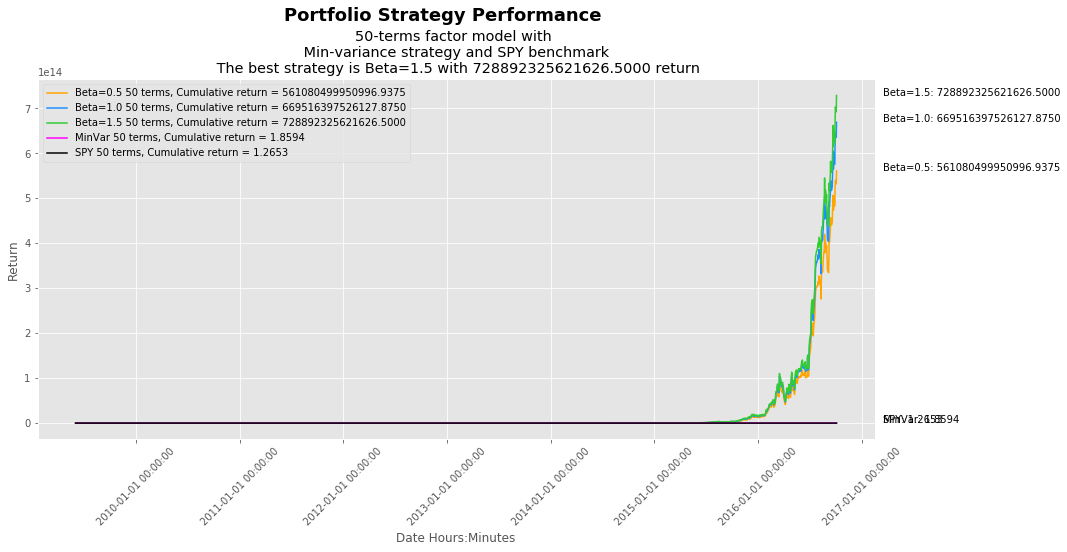

In [34]:
port_ac_short.performance_plot()

## 2.3.2 After Sub-prime crisis Short-time Risk Indicator

In [35]:
port_ac_short.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,101.107208,103.594560,104.812206,0.153858,0.117823
Daily.Mean,0.020588,0.020699,0.020800,0.000595,0.000492
Daily.Min,-0.234748,-0.224417,-0.214084,-0.038517,-0.065123
Max10.DD,-0.781556,-0.877084,-0.972004,-19.511448,-18.709385
Volatility,0.064854,0.065070,0.065902,0.007369,0.009937
Sharpe.Ratio,0.317447,0.318097,0.315620,0.080779,0.049469
Skewness,0.154278,0.150909,0.135932,-0.288927,-0.360643
Kurtosis,0.823884,0.768032,0.728952,1.527052,3.433805
Mod.VaR,-0.227074,-0.218985,-0.211603,-0.037732,-0.061743
CVaR,-0.234748,-0.224417,-0.214084,-0.038517,-0.065123


## 2.3.3 After Sub-prime crisis Short term Underlyings Analytics 

### 2.3.3.1 Beta = 0.5

In [36]:
port_ac_short.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.047932,0.032662,0.036999,-0.013867,-0.034988,0.016787,0.032390,-0.036722,0.174297,1.358611e-04,0.117823,-0.152697,0.215016,101.107208
Daily.Mean,-0.000154,0.000227,0.000213,0.000091,-0.000123,0.000193,0.000187,-0.000011,0.000698,5.489270e-07,0.000492,-0.000459,0.000949,0.020588
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.234748
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.781556
Volatility,0.009100,0.014084,0.011702,0.017089,0.006083,0.015944,0.010940,0.016590,0.010973,1.402265e-04,0.009937,0.019924,0.018755,0.064854
Sharpe.Ratio,-0.016869,0.016112,0.018188,0.005337,-0.020190,0.012123,0.017055,-0.000647,0.063621,3.914572e-03,0.049469,-0.023018,0.050623,0.317447
Skewness,0.125476,-0.166770,-0.337494,-0.278516,-0.035366,-0.056614,-0.502322,-0.024647,-0.288005,-2.704405e-01,-0.360643,0.018482,-0.205151,0.154278
Kurtosis,2.813892,3.313257,2.773041,4.491661,1.349232,1.918937,4.294709,1.432504,2.590032,4.289888e+00,3.433805,1.793756,1.710495,0.823884
Mod.VaR,-0.045002,-0.073673,-0.068533,-0.115380,-0.026142,-0.079281,-0.081690,-0.085081,-0.058136,-9.644188e-04,-0.061743,-0.089612,-0.095834,-0.227074
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.234748


### 2.3.3.2 Beta = 1.0

In [37]:
port_ac_short.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.047932,0.032662,0.036999,-0.013867,-0.034988,0.016787,0.032390,-0.036722,0.174297,1.358611e-04,0.117823,-0.152697,0.215016,103.594560
Daily.Mean,-0.000154,0.000227,0.000213,0.000091,-0.000123,0.000193,0.000187,-0.000011,0.000698,5.489270e-07,0.000492,-0.000459,0.000949,0.020699
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.224417
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.877084
Volatility,0.009100,0.014084,0.011702,0.017089,0.006083,0.015944,0.010940,0.016590,0.010973,1.402265e-04,0.009937,0.019924,0.018755,0.065070
Sharpe.Ratio,-0.016869,0.016112,0.018188,0.005337,-0.020190,0.012123,0.017055,-0.000647,0.063621,3.914572e-03,0.049469,-0.023018,0.050623,0.318097
Skewness,0.125476,-0.166770,-0.337494,-0.278516,-0.035366,-0.056614,-0.502322,-0.024647,-0.288005,-2.704405e-01,-0.360643,0.018482,-0.205151,0.150909
Kurtosis,2.813892,3.313257,2.773041,4.491661,1.349232,1.918937,4.294709,1.432504,2.590032,4.289888e+00,3.433805,1.793756,1.710495,0.768032
Mod.VaR,-0.045002,-0.073673,-0.068533,-0.115380,-0.026142,-0.079281,-0.081690,-0.085081,-0.058136,-9.644188e-04,-0.061743,-0.089612,-0.095834,-0.218985
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.224417


### 2.3.3.3 Beta = 1.5

In [38]:
port_ac_short.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.047932,0.032662,0.036999,-0.013867,-0.034988,0.016787,0.032390,-0.036722,0.174297,1.358611e-04,0.117823,-0.152697,0.215016,104.812206
Daily.Mean,-0.000154,0.000227,0.000213,0.000091,-0.000123,0.000193,0.000187,-0.000011,0.000698,5.489270e-07,0.000492,-0.000459,0.000949,0.020800
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.214084
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.972004
Volatility,0.009100,0.014084,0.011702,0.017089,0.006083,0.015944,0.010940,0.016590,0.010973,1.402265e-04,0.009937,0.019924,0.018755,0.065902
Sharpe.Ratio,-0.016869,0.016112,0.018188,0.005337,-0.020190,0.012123,0.017055,-0.000647,0.063621,3.914572e-03,0.049469,-0.023018,0.050623,0.315620
Skewness,0.125476,-0.166770,-0.337494,-0.278516,-0.035366,-0.056614,-0.502322,-0.024647,-0.288005,-2.704405e-01,-0.360643,0.018482,-0.205151,0.135932
Kurtosis,2.813892,3.313257,2.773041,4.491661,1.349232,1.918937,4.294709,1.432504,2.590032,4.289888e+00,3.433805,1.793756,1.710495,0.728952
Mod.VaR,-0.045002,-0.073673,-0.068533,-0.115380,-0.026142,-0.079281,-0.081690,-0.085081,-0.058136,-9.644188e-04,-0.061743,-0.089612,-0.095834,-0.211603
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.214084


## 2.3.4 After Sub-prime crisis Long-term model

In [39]:
port_ac_long = portfolio_startegy(data_market = ac_return, data_fama = ac_fama, term = 200)

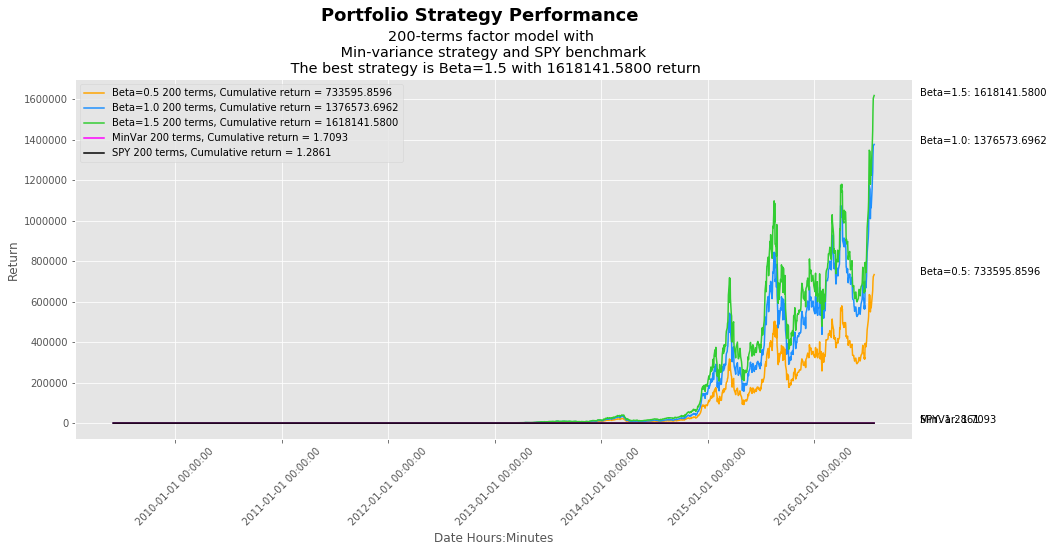

In [40]:
port_ac_long.performance_plot()

## 2.3.5 After Sub-prime crisis Long-term Risk Indicator

In [41]:
port_ac_long.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,5.624667,6.234891,6.400522,0.149741,0.122722
Daily.Mean,0.009453,0.009948,0.010031,0.000595,0.000510
Daily.Min,-0.235701,-0.248238,-0.273133,-0.033761,-0.065123
Max10.DD,-0.816215,-0.882385,-1.026313,-129.831211,-18.709385
Volatility,0.061976,0.064210,0.064047,0.009094,0.010019
Sharpe.Ratio,0.152530,0.154930,0.156612,0.065451,0.050877
Skewness,-0.067896,-0.085734,-0.115177,-0.125005,-0.358718
Kurtosis,1.329354,1.199020,1.187526,1.454225,3.372999
Mod.VaR,-0.233386,-0.246392,-0.267158,-0.033635,-0.061834
CVaR,-0.235701,-0.248238,-0.273133,-0.033761,-0.065123


## 2.3.6 After Sub-prime crisis Long-term Underlyings Analytics

### 2.3.6.1 Beta = 0.5

In [42]:
port_ac_long.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.044862,0.029932,0.030759,-0.018353,-0.038312,0.017925,0.038601,-0.041563,0.172864,2.030714e-04,0.122722,-0.167212,0.204875,5.624667
Daily.Mean,-0.000140,0.000218,0.000190,0.000076,-0.000136,0.000199,0.000211,-0.000030,0.000694,8.152447e-07,0.000510,-0.000529,0.000917,0.009453
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.235701
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.816215
Volatility,0.009172,0.014202,0.011772,0.017252,0.006132,0.016022,0.011005,0.016611,0.011067,1.377464e-04,0.010019,0.019834,0.018786,0.061976
Sharpe.Ratio,-0.015272,0.015356,0.016116,0.004401,-0.022210,0.012420,0.019182,-0.001829,0.062735,5.918448e-03,0.050877,-0.026666,0.048798,0.152530
Skewness,0.121475,-0.160605,-0.342738,-0.272790,-0.032334,-0.062115,-0.497532,-0.008137,-0.283586,-2.350540e-01,-0.358718,0.015633,-0.198909,-0.067896
Kurtosis,2.775996,3.254540,2.755787,4.404074,1.313183,1.904346,4.254725,1.447149,2.527796,4.349110e+00,3.372999,1.909254,1.749189,1.329354
Mod.VaR,-0.045022,-0.073695,-0.068581,-0.115562,-0.026163,-0.079342,-0.081855,-0.085197,-0.058192,-9.653270e-04,-0.061834,-0.089652,-0.095974,-0.233386
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.235701


### 2.3.6.2 Beta = 1.0

In [43]:
port_ac_long.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.044862,0.029932,0.030759,-0.018353,-0.038312,0.017925,0.038601,-0.041563,0.172864,2.030714e-04,0.122722,-0.167212,0.204875,6.234891
Daily.Mean,-0.000140,0.000218,0.000190,0.000076,-0.000136,0.000199,0.000211,-0.000030,0.000694,8.152447e-07,0.000510,-0.000529,0.000917,0.009948
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.248238
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.882385
Volatility,0.009172,0.014202,0.011772,0.017252,0.006132,0.016022,0.011005,0.016611,0.011067,1.377464e-04,0.010019,0.019834,0.018786,0.064210
Sharpe.Ratio,-0.015272,0.015356,0.016116,0.004401,-0.022210,0.012420,0.019182,-0.001829,0.062735,5.918448e-03,0.050877,-0.026666,0.048798,0.154930
Skewness,0.121475,-0.160605,-0.342738,-0.272790,-0.032334,-0.062115,-0.497532,-0.008137,-0.283586,-2.350540e-01,-0.358718,0.015633,-0.198909,-0.085734
Kurtosis,2.775996,3.254540,2.755787,4.404074,1.313183,1.904346,4.254725,1.447149,2.527796,4.349110e+00,3.372999,1.909254,1.749189,1.199020
Mod.VaR,-0.045022,-0.073695,-0.068581,-0.115562,-0.026163,-0.079342,-0.081855,-0.085197,-0.058192,-9.653270e-04,-0.061834,-0.089652,-0.095974,-0.246392
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.248238


### 2.3.6.3 Beta = 1.5

In [44]:
port_ac_long.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.044862,0.029932,0.030759,-0.018353,-0.038312,0.017925,0.038601,-0.041563,0.172864,2.030714e-04,0.122722,-0.167212,0.204875,6.400522
Daily.Mean,-0.000140,0.000218,0.000190,0.000076,-0.000136,0.000199,0.000211,-0.000030,0.000694,8.152447e-07,0.000510,-0.000529,0.000917,0.010031
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.273133
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-1.026313
Volatility,0.009172,0.014202,0.011772,0.017252,0.006132,0.016022,0.011005,0.016611,0.011067,1.377464e-04,0.010019,0.019834,0.018786,0.064047
Sharpe.Ratio,-0.015272,0.015356,0.016116,0.004401,-0.022210,0.012420,0.019182,-0.001829,0.062735,5.918448e-03,0.050877,-0.026666,0.048798,0.156612
Skewness,0.121475,-0.160605,-0.342738,-0.272790,-0.032334,-0.062115,-0.497532,-0.008137,-0.283586,-2.350540e-01,-0.358718,0.015633,-0.198909,-0.115177
Kurtosis,2.775996,3.254540,2.755787,4.404074,1.313183,1.904346,4.254725,1.447149,2.527796,4.349110e+00,3.372999,1.909254,1.749189,1.187526
Mod.VaR,-0.045022,-0.073695,-0.068581,-0.115562,-0.026163,-0.079342,-0.081855,-0.085197,-0.058192,-9.653270e-04,-0.061834,-0.089652,-0.095974,-0.267158
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081519,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.273133


# 3. Conclusion

- $\beta = 1.5$ outperforms all periods except during the sub-prime crisis but $\beta = 0.5$ instead outperforms during the sub-prime crisis. This means that during the crisis, performing strategy less volatile than benchmark is a better choice. On the other hand, performing strategy more volatile than benchmark is better for all periods except crisis time. 
- Before crisis, as we can see, the results of strategy are more stable. This means that we will make and lose profit lower than the other periods.
- In the time of crisis, this doesn't mean we cannot make a lot of profit. As we can see that when we rebalance more frequently during the crisis to long and short correctly, we can make the heighest profit at that time. However, if we don't perform the strategy correctly, we will gain the least profit.
- After the crisis, the markets seem to recover. When we perform the strategy correctly, we can make higher profit than before the crisis but if not, we will make profit lower.